# Nested Sampling in `LITMUS`
In this tutorial, we'll show how to use `LITMUS`'s nested sampling implementation. You might need to use nested sampling if:
1. Your non-lag posteriors are highly non-gaussian (typical for low SNR sources), or
2. You need a _really_ precise calculation of the evidence,  

And you should _only_ use it when:  
1. Your model doesn't have heaps of parameters
2. You don't particular care about waiting a while for the results.

In [1]:
import matplotlib.pyplot as plt

import litmus.fitting_methods
from litmus import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


First, per normal we'll use the `mocks` module to generate some mock data:

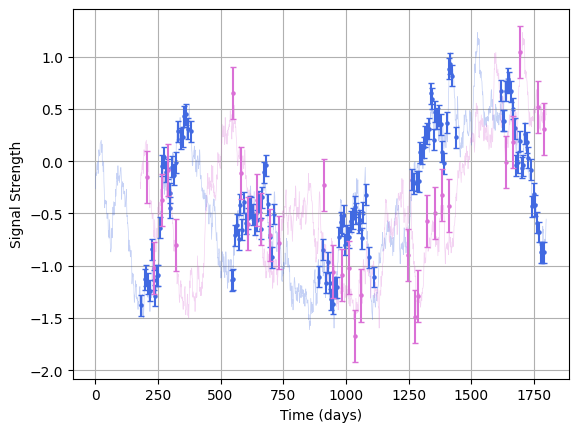

In [2]:
mock = litmus.mocks.mock(lag=180,
                         E=[0.1, 0.25],
                         tau=400)
lc_1, lc_2 = mock.lc_1, mock.lc_2
mock.plot()
plt.show()

Now, choose a stats model to fit from the `models` module. In our case this will be `GP_simple`, the simplest lag recovery model. Nested sampling as a method doesn't have the nicest scaling with model dimensions, so we'll fix a few of the parameters at their true values to keep the dimensionality low.

In [3]:
model = litmus.models.GP_simple(verbose=False,
                                debug=False,
                                prior_ranges=mock.params() | {'lag': [0, 1_000], 
                                                              'logtau': [np.log(10), np.log(10000)],
                                                              'logamp': [np.log(0.1), np.log(10)]
                                                              }
                                )

Now we make a nested sampler from the `fitting_methods` module. `LITMUS`'s nested sampling makes use of the implementation in [JAXNS](https://jaxns.readthedocs.io/en/latest), and you can defer to the documentation there for specifics about the inner workings. For the `nested_sampler` fitter, we've got a few dials we can turn to tune the sampler. See the docs for more detail, but in short, we can set the following:

| Argument                | Description                                                                                |
|-------------------------|--------------------------------------------------------------------------------------------|
| `num_live_points`       | Number of live points to use in nested sampling fitting. Defaults to `500`.                |
| `max_samples`           | Maximum samples before terminating the run. Defaults to `10_000`.                          |
| `num_parallel_samplers` | Number of parallel samplers to fit with. Defaults to `1`.                                  |
| `evidence_uncert`       | Termination condition for evidence uncertainty. Default to `1E-3`.                         |
| `live_evidence_frac`    | Termination condition for live fraction of evidence remaining. Defaults to `log(1 + 1e-3)`. |



Once that's set up we can run the fitter. Note that nested sampling is a markedly slower fitting method, and can take a fair while to converge even in small dimensions. It's best to use it as a fallback if you're worried that LITMUS's `hessian_scan` and `svi_scan` methods aren't capturing non-gaussianity properly, or if they seem to be having a hard time generating a nice set of test lags.

In [22]:
fitter = litmus.fitting_methods.nested_sampling(model,
                                                num_live_points = 2_000,
                                                max_samples = 50_000,
                                                evidence_uncert = 1E-4
                                                )
fitter.fit(*mock.lcs())

INFO:jaxns:Number of parallel Markov-chains set to: 2000


Once we have everything all set up nicely, we can call `JAXNS` internal diagnostic window to check that everything's run properly. If you don't know how to interpret these, check out this [nested sampling tutorial](https://hughmcdougall.github.io/blog/03_stats/01_nestedsampling/page.html):

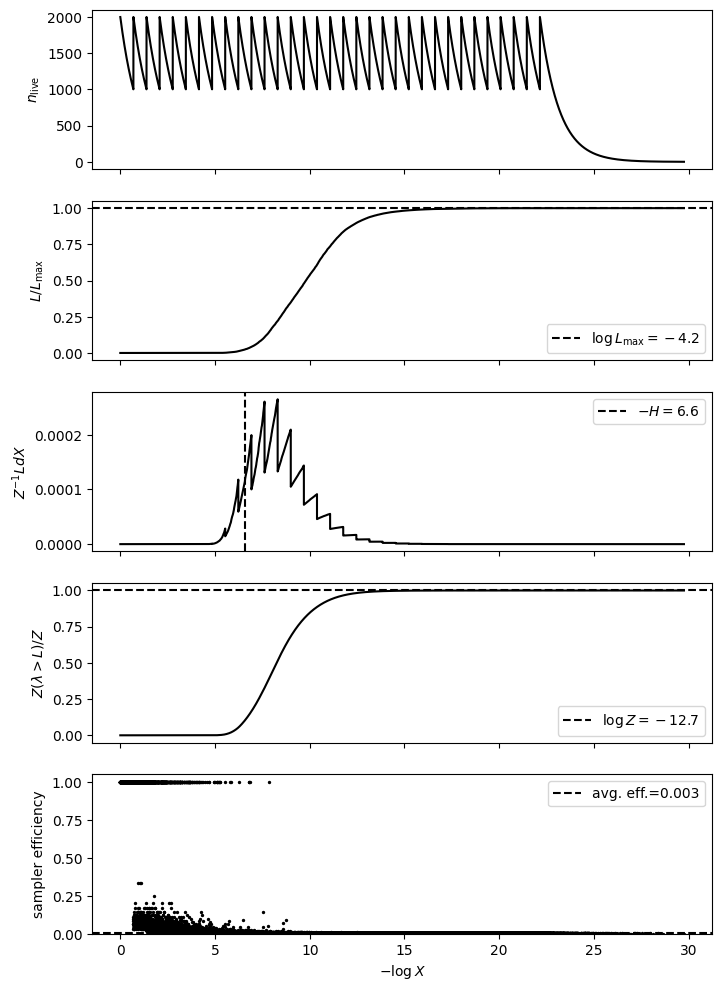

<Figure size 640x480 with 0 Axes>

In [28]:
fitter.diagnostics()
plt.show()  

If you need to get a hold of the internals moving parts from `JAXNS`, you can get:
1. The JAXNS sampler via `fitter.sampler`
2. The JAXNS result object via `fitter._jaxnsresults`
3. The JAXNS termination condition via `fitter._jaxnstermination`

To get results we just call the `get_samples()` and `get_evidence()` functions like we normally would. 

In [29]:
Z = fitter.get_evidence()
Z, Zem, Zep = Z

print("The model evidence is between log10(Z) = %.2f and %.2f" %(np.log10(Z+Zem), np.log10(Z+Zep)))

The model evidence is between log10(Z) = -5.53 and -5.47


Doing a quick histogram we can see how well the nested sampler has recovered the lag posterior.

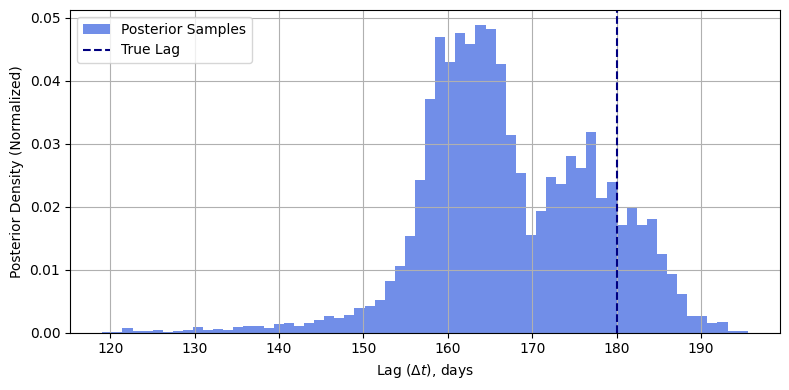

In [30]:
samples = fitter.get_samples(10_000)

#----------------------
plt.figure(figsize=(8,4))
plt.hist(samples["lag"], bins = 64, density=True, color = "royalblue", alpha=0.75, label = "Posterior Samples")
plt.grid()
plt.axvline(mock.lag, label = "True Lag", ls='--', color = "navy")
plt.xlabel("Lag ($\Delta t$), days")
plt.ylabel("Posterior Density (Normalized)")
plt.tight_layout()
plt.grid(True)
plt.legend()

plt.show()

And throwing this off to a `LITMUS` plotter object we can see how well it's constrained the _other_ parameters:

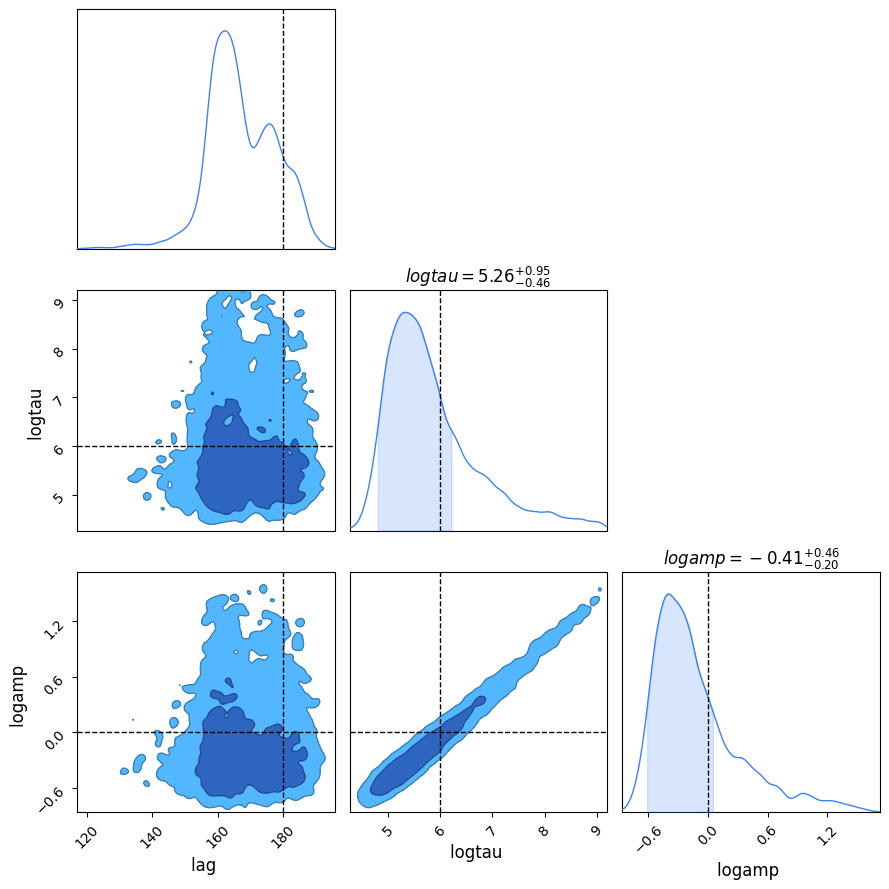

In [33]:
C = litmus.LITMUS(fitter)
C.plot_parameters(truth = mock.params(), Nsamples = 10_000)
plt.show()

Notice that, even though we're using the same model / data as the lightcurve constraint example, this model has _much_ higher uncertainty in the lag. This is because, in that example, we fixed `logamp=0.0`. The damped random walk has a strong correlation between `logtau` and `logamp`, and for low SNR sources like this that spirals out into a near degeneracy. In cases like this, hessian_scan and SVI_scan will still do _okay_ at recovering the lag, but might give some misleading result for the highly non-gaussian non-lag parameters. This is a textbook case of where nested sampling would be useful.